# Colab install and settings

If you intend to run this notebook on Colab, run the following; otherwise you can skip this part.

In [7]:
!pip install sentinelsat
!pip install rasterio
!pip install folium
!apt install gdal-bin python-gdal python3-gdal 
!apt install python3-rtree 
!pip install git+git://github.com/geopandas/geopandas.git
!pip install descartes 

'apt' is not recognized as an internal or external command,
operable program or batch file.
'apt' is not recognized as an internal or external command,
operable program or batch file.


  Running command git clone --filter=blob:none --quiet git://github.com/geopandas/geopandas.git 'C:\Users\caroline.stehle\AppData\Local\Temp\pip-req-build-jguyxs57'



  Cloning git://github.com/geopandas/geopandas.git to c:\users\caroline.stehle\appdata\local\temp\pip-req-build-jguyxs57
  Resolved git://github.com/geopandas/geopandas.git to commit 51864acf3dd0bcbc74b2a922c6e012d7e57e46b5
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for geopandas: filename=geopandas-0+untagged.1552.g51864ac-py2.py3-none-any.whl size=1037522 sha256=bfa17e18be4eaee740b465dc610f34c38c3b1155689f93fa2c550b85f3a3f966
  Stored in directory: C:\Users\caroline.stehle\AppData\Local\Temp\pip-ephem-wheel-cache-f1281z83\wheels\37\ce\df\09721a3e578b57e217d038d0555fd872eba4e1fd9c8f6c8013
Successfully built geopandas
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.10.2
    Uninstalling geopandas-0.10.2:
      Successfully uninstalled geopandas-0.10.2


In [23]:
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd '/content/drive/MyDrive/Colab Notebooks/'

/content/drive/MyDrive/Colab Notebooks


# Introduction

This Notebook was intended to get semi-automatically multi-spectral images of reduced size which could be used at entry of Neural network for green (vegetation) areas detection.

As first step, we need  images with full urban areas or full vegetation areas. This is why we need to crop images to get only reduced images with the area of interest.

Before running this Jupyter notebook, I searched the GPS coordinates of a dense urban area on OpenStreetMap -> Export
. 
In the Notebook, we create a shapefile, make a query on Copernicus hub with Sentinel API to get a corresponding satellite file. 
We select the 10m and 20m resolution bands and we oversample 20m resolution bands. At the end we crop all bands of satellite image corresponding to the shapefile over the area of interest and we create a new tiff multispectral image with all the bands. This image still contains the metadata information to locate the image on a map (with folium for instance).

The same procedure must be repeated for a dense green area, and for a mix area.

The area of interest is a rectangle, but we could create more complex shapes with holes, etc.

# Create shapefile over area of interest

Reference tutorial: https://pypi.org/project/pyshp/#writing-shapefiles


In [4]:
from sat_tools import create_shapefile_from_geo_coordinates
from sat_tools import create_list_of_points_from_geo_coordinates

Here we create a simple polygon shapefile, which is a square composed of GPS coordinates (latitude, longitude) in clockwise order. Latitude and longitude of area of interest can be found with www.openstreetmap.org -> Export


In the following, choose 1 cell to run, depending on which file you want to generate, and then go to next section (NB: I choose areas which correspond to the same satellite image, so that we don't need to download 3 times a new satellite image -> we reuse the same)

In [5]:
area = 'Puebla'
shapefilename = area + '_' + 'shapefile'
fieldname = 'urban'
N_lat = 19.1062
S_lat = 18.9813
W_long = -98.2894
E_long = -98.1731
create_shapefile_from_geo_coordinates(shapefilename, fieldname, N_lat, S_lat, W_long, E_long)


We do the same for a green area:

In [6]:
area = 'Popocatepetl'
shapefilename = area + '_' + 'shapefile'
fieldname = 'nature'
N_lat = 19.3098
S_lat = 19.0981
W_long = -98.7381
E_long = -98.5573
create_shapefile_from_geo_coordinates(shapefilename, fieldname, N_lat, S_lat, W_long, E_long)


And for a mixed urban/green area:

In [7]:
area = 'Tlaxcala'
shapefilename = area + '_' + 'shapefile'
fieldname = 'mixed'
N_lat = 19.3509
S_lat = 19.3118
W_long = -98.2599
E_long = -98.2154
create_shapefile_from_geo_coordinates(shapefilename, fieldname, N_lat, S_lat, W_long, E_long)


In [8]:
area = 'Roquefort'
shapefilename = area + '_' + 'shapefile'
fieldname = 'mixed'
N_lat = 43.7085
S_lat = 43.6363
W_long = 6.9929
E_long = 7.1204
create_shapefile_from_geo_coordinates(shapefilename, fieldname, N_lat, S_lat, W_long, E_long)
area_points_list = create_list_of_points_from_geo_coordinates(N_lat, S_lat, W_long, E_long)

# Visualise area of interest with geopandas and folium

Reference tutorial:
https://towardsdatascience.com/satellite-imagery-access-and-analysis-in-python-jupyter-notebooks-387971ece84b

In [9]:
import folium
import os
import numpy as np

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt 
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import MultiPolygon, Polygon
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
import fiona

Read shapefile with Geopandas and visualize it with Folium python library.

In [10]:
area_shape = gpd.read_file(shapefilename + '.shp')
area_shape

,mixed,geometry
0,polygon1,"POLYGON ((6.99290 43.70850, 7.12040 43.70850, ..."


We need to specify the CRS: Coordinate Reference System with an EPSG code, otherwise the shapefile is unusable.

**EPSG** stands for European Petroleum Survey Group and is an organization that maintains a geodetic parameter database with standard codes, the EPSG codes, for coordinate systems, datums, spheroids, units... 

Common EPSG codes (Source: Wikipedia)

**EPSG:4326** - WGS 84, latitude/longitude coordinate system based on the Earth's center of mass, used by the Global Positioning System among others.

**EPSG:3857** - Web Mercator projection used for display by many web-based mapping tools, including Google Maps and OpenStreetMap.

**EPSG:7789** - International Terrestrial Reference Frame 2014 (ITRF2014), an Earth-fixed system that is independent of continental drift.

In [11]:
#area_shape.crs = {'init':"epsg:4326"}

from pyproj import CRS
area_shape.crs = CRS("EPSG:4326")

In [12]:
# Center the map at the center of the area of interest, thanks to latitude and longitude coordinates:
m = folium.Map([(N_lat+S_lat)/2,(W_long+E_long)/2], zoom_start=11)

# Visualise the map and the shape of the area
folium.GeoJson(area_shape).add_to(m)
m

Create a footprint from the shapefile geometry. Here we will use Shapely Python library since our data is in Shapefiles and read it already as Geopandas GeodataFrame. (Note that if you have Geojson data, Sentinelsat provides a handy way to convert your data into a proper format in the query).

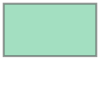

In [13]:
footprint = None
for i in area_shape['geometry']:
    footprint = i
    
footprint

# Download satellite file corresponding to footprint with Sentinel API

Before we are able to use sentinelsat, we need to register a username in [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/home) and note down your username and password and paste them here inside the code.

In [14]:
user = 'cstehle' 
password = 'mdpCopernicus01'

api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

Run a query for Sentinel-2 images with Level 2A with cloud coverage between 0 and 2 % that fall or intersect with the footprint (Area of study). For the time period, we are interested in Sentinel Level 2A satellite images taken between '20210201' and '20210228' (For reference on valid search queries please refer to [scihub](https://scihub.copernicus.eu/twiki/do/view/SciHubUserGuide/FullTextSearch?redirectedfrom=SciHubUserGuide.3FullTextSearch)).

In [15]:
# Remark: if we do the search with the area footprint as a polygon or rectangle, 
# we perform a Geographical search of the products 
# whose footprint intersects or is included in the given area footprint.
# products = api.query(footprint,
#                   date = ('20210201', '20210430'),
#                   platformname = 'Sentinel-2',
#                   processinglevel = 'Level-2A',
#                   cloudcoverpercentage = (0,2))

In [16]:
# To be sure that the whole rectangle that we want is included in the satellite image, 
# we perform 4 searches that include points = the corners of the rectangle of interest
# and we look for the intersection of these searches:
prod = []
for p in area_points_list:
   res = api.query(p,
                     date = ('20220101', '20220228'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,2))
   prod.append(res)

shared_keys = prod[0].keys() & prod[1].keys() & prod[2].keys() & prod[3].keys()
dict_intersection = {k: prod[0][k] for k in shared_keys }
products = dict_intersection

We get a dictionary of all products available in this period with the query specification.

In [15]:
# Check number of products from the query
if len(products) > 0:
   print("Number of products found: ",len(products))
else:
   print("No products found. Try to rerun the query by changing the parameters (ex: increase cloudcoverpercentage or date window) ")   

Number of products found:  9


From here we can create a GeodataFrame or Dataframe from the product dictionary and sort them according to cloud coverage percentage.

In [16]:
products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted

,title,link,link_alternative,link_icon,summary,ondemand,generationdate,beginposition,endposition,ingestiondate,...,producttype,platformidentifier,orbitdirection,platformserialidentifier,processinglevel,datastripidentifier,granuleidentifier,identifier,uuid,geometry
11c5e6f2-18e3-49c7-a6e7-d4c150ee2869,S2B_MSIL2A_20220129T103159_N0400_R108_T32TLP_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-01-29T10:31:59.024Z, Instrument: MS...",false,2022-01-29 12:09:45,2022-01-29 10:31:59.024,2022-01-29 10:31:59.024,2022-01-29 16:39:34.397,...,S2MSI2A,2017-013A,DESCENDING,Sentinel-2B,Level-2A,S2B_OPER_MSI_L2A_DS_VGS4_20220129T120945_S2022...,S2B_OPER_MSI_L2A_TL_VGS4_20220129T120945_A0255...,S2B_MSIL2A_20220129T103159_N0400_R108_T32TLP_2...,11c5e6f2-18e3-49c7-a6e7-d4c150ee2869,"MULTIPOLYGON (((6.53677 43.23826, 7.77074 43.2..."
f1e4dcb6-cd48-4dc9-a1fa-7824cc45abc0,S2B_MSIL2A_20220208T103109_N0400_R108_T32TLP_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-02-08T10:31:09.024Z, Instrument: MS...",false,2022-02-08 14:35:49,2022-02-08 10:31:09.024,2022-02-08 10:31:09.024,2022-02-08 18:48:57.754,...,S2MSI2A,2017-013A,DESCENDING,Sentinel-2B,Level-2A,S2B_OPER_MSI_L2A_DS_VGS2_20220208T143549_S2022...,S2B_OPER_MSI_L2A_TL_VGS2_20220208T143549_A0257...,S2B_MSIL2A_20220208T103109_N0400_R108_T32TLP_2...,f1e4dcb6-cd48-4dc9-a1fa-7824cc45abc0,"MULTIPOLYGON (((6.53677 43.23826, 7.76332 43.2..."
307cb3e2-8d66-4683-8ec9-2a9f5a8ff1f3,S2A_MSIL2A_20220210T102151_N0400_R065_T32TLP_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-02-10T10:21:51.024Z, Instrument: MS...",false,2022-02-10 15:34:00,2022-02-10 10:21:51.024,2022-02-10 10:21:51.024,2022-02-10 21:28:40.939,...,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_OPER_MSI_L2A_DS_VGS2_20220210T153400_S2022...,S2A_OPER_MSI_L2A_TL_VGS2_20220210T153400_A0346...,S2A_MSIL2A_20220210T102151_N0400_R065_T32TLP_2...,307cb3e2-8d66-4683-8ec9-2a9f5a8ff1f3,"MULTIPOLYGON (((6.53677 43.23826, 7.88868 43.2..."
33adc1cd-3206-4dc9-9e00-9f779f6c4226,S2A_MSIL2A_20220223T103031_N0400_R108_T32TLP_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-02-23T10:30:31.024Z, Instrument: MS...",false,2022-02-23 15:41:41,2022-02-23 10:30:31.024,2022-02-23 10:30:31.024,2022-02-23 21:38:41.575,...,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_OPER_MSI_L2A_DS_VGS2_20220223T154141_S2022...,S2A_OPER_MSI_L2A_TL_VGS2_20220223T154141_A0348...,S2A_MSIL2A_20220223T103031_N0400_R108_T32TLP_2...,33adc1cd-3206-4dc9-9e00-9f779f6c4226,"MULTIPOLYGON (((6.53677 43.23826, 7.75939 43.2..."
b40cf9be-10e3-4fd3-a78a-41c6f8695175,S2A_MSIL2A_20220121T102331_N0301_R065_T32TLP_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-01-21T10:23:31.024Z, Instrument: MS...",false,2022-01-21 13:15:36,2022-01-21 10:23:31.024,2022-01-21 10:23:31.024,2022-01-21 16:31:30.468,...,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_OPER_MSI_L2A_DS_VGS2_20220121T131536_S2022...,S2A_OPER_MSI_L2A_TL_VGS2_20220121T131536_A0343...,S2A_MSIL2A_20220121T102331_N0301_R065_T32TLP_2...,b40cf9be-10e3-4fd3-a78a-41c6f8695175,"MULTIPOLYGON (((6.53677 43.23826, 7.88868 43.2..."
3b8bc993-52ff-4b0a-af7b-c083ab8c5bb2,S2A_MSIL2A_20220124T103331_N0301_R108_T32TLP_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-01-24T10:33:31.024Z, Instrument: MS...",false,2022-01-24 16:37:34,2022-01-24 10:33:31.

In [17]:
# A geopandas dataframe is a pandas dataframe with a geometry column
type(products_gdf_sorted)

geopandas.geodataframe.GeoDataFrame

Download image of interest: first image in the list that has less could percentage, and for which download is successful 

In [18]:
from sat_tools import extractFile

In [20]:
download_OK = False
product_idx = 0
while not download_OK and (product_idx < len(products)):
  try: # it can happen that the download is incomplete or file is not any more on the sentinel server
    sat_image_uuid = products_gdf_sorted['uuid'][product_idx]
    api.download(sat_image_uuid)
    sat_image_id = products_gdf_sorted['identifier'][product_idx]
    zipfilename = products_gdf_sorted['identifier'][product_idx] + ".zip"
    extractFile(zipfilename, 'Sentinel2_images/') 
    download_OK = True
  except:
    product_idx = product_idx + 1

MD5 checksumming:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

In [21]:
if download_OK:
  print("index found:", product_idx )
  print("zipfilename:", zipfilename )
else:
   print("No downloadable product. Try to rerun the Sentinel API query by changing the parameters (ex: increase cloudcoverpercentage or date window) ")     

index found: 1
zipfilename: S2B_MSIL2A_20220208T103109_N0400_R108_T32TLP_20220208T143549.zip


In [39]:
ls -l *.zip

 Volume in drive C is Acer
 Volume Serial Number is 0EE5-46F4

 Directory of C:\Users\caroline.stehle\DSTI-sat-project\how-green-is\notebooks


 Directory of C:\Users\caroline.stehle\DSTI-sat-project\how-green-is\notebooks

03/08/2022  04:04 PM     1,080,554,612 S2B_MSIL2A_20220208T103109_N0400_R108_T32TLP_20220208T143549.zip
               1 File(s)  1,080,554,612 bytes
               0 Dir(s)  846,356,725,760 bytes free


In [17]:
# If you don't want to download satellite file (which could take 30 min), use pre-downloaded file
sat_image_id = "S2B_MSIL2A_20220208T103109_N0400_R108_T32TLP_20220208T143549"

# Select 10m bands and create RGB image (RGB.tiff)

Here is a table with Sentinel2 bands description:

Band| Resolution	| Central Wavelength |	Description
----|---------------|--------------------|-------------
B1	| 60 m	| 443 nm	| Ultra blue (Coastal and Aerosol)
B2	| 10 m	| 490 nm	| Blue
B3	| 10 m	| 560 nm	| Green
B4	| 10 m	| 665 nm	| Red
B5	| 20 m	| 705 nm	| Visible and Near Infrared (VNIR)
B6	| 20 m	| 740 nm	| Visible and Near Infrared (VNIR)
B7	| 20 m	| 783 nm	| Visible and Near Infrared (VNIR)
B8	| 10 m	| 842 nm	| Visible and Near Infrared (VNIR)
B8a	| 20 m	| 865 nm	| Visible and Near Infrared (VNIR)
B9	| 60 m	| 940 nm	| Short Wave Infrared (SWIR)
B10	| 60 m	| 1375 nm	| Short Wave Infrared (SWIR)
B11	| 20 m	| 1610 nm	| Short Wave Infrared (SWIR)
B12	| 20 m	| 2190 nm	| Short Wave Infrared (SWIR)

In this part we select only the 10m bands, that is to say bands B2, B3, B4 and B8.

In [18]:
import glob2

In [19]:
common_path = 'Sentinel2_images/' + sat_image_id + '.SAFE/GRANULE/*/IMG_DATA/'

In [20]:
#check if the contents of the zip file have been actually extracted
#glob2.glob returns a list of files in a directory
assert len(glob2.glob(common_path + '*')) > 0

Let's work only on 10 bands resolution to start.
We'll deal with different resolution bands later...

In [21]:
# Open Bands 8, 4, 3 and 2 with Rasterio
R10 = common_path + 'R10m'

b2 = rio.open(glob2.glob(R10+'/*_B02_10m.jp2')[0])
b3 = rio.open(glob2.glob(R10+'/*_B03_10m.jp2')[0])
b4 = rio.open(glob2.glob(R10+'/*_B04_10m.jp2')[0])
b8 = rio.open(glob2.glob(R10+'/*_B08_10m.jp2')[0])


In [22]:
b4.count, b4.width, b4.height

(1, 10980, 10980)

In [23]:
# Optional : Create RGB image
image_name="RGB_" + area + ".tiff"
with rio.open(image_name,'w',driver='Gtiff', width=b4.width, height=b4.height, 
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as dst:
    dst.write(b4.read(1),1) # Red 
    dst.write(b3.read(1),2) # Green
    dst.write(b2.read(1),3) # Blue
    dst.close()

In [24]:
from sat_tools import plot_RGB_raster

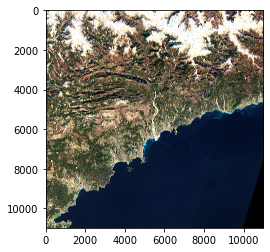

In [25]:
# Plot nicely the resulting RGB image, using percentile rescaling
plot_RGB_raster(image_name, scaling_method="pct", pct=[2,90])

# Select and upsample 20m bands

In [26]:
# Open Bands 5, 6 and 7, 8A, 11, 12 with Rasterio
R20 = common_path + 'R20m'

b5 = rio.open(glob2.glob(R20+'/*_B05_20m.jp2')[0])
b6 = rio.open(glob2.glob(R20+'/*_B06_20m.jp2')[0])
b7 = rio.open(glob2.glob(R20+'/*_B07_20m.jp2')[0])
b8A = rio.open(glob2.glob(R20+'/*_B8A_20m.jp2')[0])
b11 = rio.open(glob2.glob(R20+'/*_B11_20m.jp2')[0])
b12 = rio.open(glob2.glob(R20+'/*_B12_20m.jp2')[0])

In [27]:
b5.count, b5.width, b5.height

(1, 5490, 5490)

20m resolution images are smaller than the 10m resolution images. To run our NN we need images of same size and therefore we need to upsample the 20m resolution images. To be sure to obtain images of same size after croping, we need to resample first, and then apply the mask corresponding to the area of interest (otherwise there can be a difference of 2 pixels)

In [28]:
from sat_tools import resample_image

In [29]:
# Loop to resample 20m bands images
for (band, bandchar) in zip((b5, b6, b7, b8A, b11, b12), ("b5", "b6", "b7", "b8A", "b11", "b12")):
  out_image, out_transform = resample_image(band, upscale_factor=2)
  out_meta = band.meta.copy()
  out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
  with rasterio.open(bandchar+"_r.tif", "w", **out_meta) as dest:
    dest.write(out_image)

# Mask Satellite images

In [30]:
# Check what is the crs of the file to mask
src = rasterio.open("RGB_" + area + ".tiff") 

In [31]:
print(src.crs)

EPSG:32632


In [32]:
# Change the projection 
area_shape_proj = area_shape.to_crs(src.crs)
area_shape_proj

,mixed,geometry
0,polygon1,"POLYGON ((338295.245 4841454.909, 348567.634 4..."


In [33]:
# Optional: crop RGB image
with rio.open("RGB_" + area + ".tiff") as src:
    out_image, out_transform = rio.mask.mask(src, area_shape_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rasterio.open("RGB_" + area + "_masked.tiff", "w", **out_meta) as dest:
    dest.write(out_image)

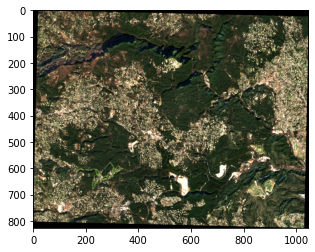

In [34]:
# Plot nicely the resulting RGB image, using percentile rescaling
plot_RGB_raster("RGB_" + area + "_masked.tiff", scaling_method="pct", pct=[5,98])

In [35]:
# Loop to crop all single bands images for the area
for (band, bandchar) in zip((b2, b3, b4, b8), ("b2", "b3", "b4", "b8")):
  out_image, out_transform = rio.mask.mask(band, area_shape_proj.geometry,crop=True)
  out_meta = band.meta.copy()
  out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
  with rasterio.open(area + "_" + bandchar + "_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [36]:
# Loop to crop resampled bands images for the area
for bandchar in ("b5_r", "b6_r", "b7_r", "b8A_r", "b11_r", "b12_r"):
  band = rasterio.open(bandchar+".tif")
  out_image, out_transform = rio.mask.mask(band, area_shape_proj.geometry,crop=True)
  out_meta = band.meta.copy()
  out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
  with rasterio.open(area + "_" + bandchar + "_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

Comparison of images sizes obtained with 10m resolution (without resampling) and 20 m resolution after resampling : they should be equal

In [37]:
# 10m band after croping only :
with rio.open(area + '_' + 'b4_masked.tif', 'r') as ds:
    tmp = ds.read()  
print(tmp.shape)

(1, 827, 1047)


In [38]:
# After resampling then croping:
with rio.open(area + '_' + 'b5_r_masked.tif', 'r') as ds:
    area_b5_r_raster = ds.read()  
print(area_b5_r_raster.shape)

(1, 827, 1047)


# Create multiband image (allbands.tiff) for croped area

In [39]:
# Create 1 single tiff file with all bands
b2 = rio.open(area + '_' + 'b2_masked.tif')
b3 = rio.open(area + '_' + 'b3_masked.tif')
b4 = rio.open(area + '_' + 'b4_masked.tif')
b5_r = rio.open(area + '_' + 'b5_r_masked.tif')
b6_r = rio.open(area + '_' + 'b6_r_masked.tif')
b7_r = rio.open(area + '_' + 'b7_r_masked.tif')
b8 = rio.open(area + '_' + 'b8_masked.tif')
b8A_r = rio.open(area + '_' + 'b8A_r_masked.tif')
b11_r = rio.open(area + '_' + 'b11_r_masked.tif')
b12_r = rio.open(area + '_' + 'b12_r_masked.tif')

with rio.open(area + '_' + 'allbands.tiff','w',driver='Gtiff', width=b2.width, height=b2.height, 
              count=10,crs=b2.crs,transform=b2.transform, dtype=b2.dtypes[0]) as dst:
    dst.write(b2.read(1),1) 
    dst.write(b3.read(1),2) 
    dst.write(b4.read(1),3) 
    dst.write(b5_r.read(1),4) 
    dst.write(b6_r.read(1),5) 
    dst.write(b7_r.read(1),6) 
    dst.write(b8.read(1),7) 
    dst.write(b8A_r.read(1),8) 
    dst.write(b11_r.read(1),9) 
    dst.write(b12_r.read(1),10) 
    dst.close()


In [40]:
with rio.open(area + '_' + 'allbands.tiff', 'r') as ds:
    featuresArea = ds.read()  # read all raster values

print(featuresArea.shape)  # this is a 3D numpy array, with dimensions [band, row, col]


(10, 827, 1047)


In [41]:
# do some cleaning of intermediate tif files 
# and move final tiff files (multiband) in folder Sentinel2_images 

In [42]:
!rm *.tif

rm: cannot remove 'Roquefort_b11_r_masked.tif': Device or resource busy
rm: cannot remove 'Roquefort_b12_r_masked.tif': Device or resource busy
rm: cannot remove 'Roquefort_b2_masked.tif': Device or resource busy
rm: cannot remove 'Roquefort_b3_masked.tif': Device or resource busy
rm: cannot remove 'Roquefort_b4_masked.tif': Device or resource busy
rm: cannot remove 'Roquefort_b5_r_masked.tif': Device or resource busy
rm: cannot remove 'Roquefort_b6_r_masked.tif': Device or resource busy
rm: cannot remove 'Roquefort_b7_r_masked.tif': Device or resource busy
rm: cannot remove 'Roquefort_b8A_r_masked.tif': Device or resource busy
rm: cannot remove 'Roquefort_b8_masked.tif': Device or resource busy
rm: cannot remove 'b12_r.tif': Device or resource busy


In [43]:
!mv *.tiff ./Sentinel2_images/

mv: cannot move 'RGB_Roquefort_masked.tiff' to './Sentinel2_images/RGB_Roquefort_masked.tiff': Device or resource busy


In [45]:
ls *.tif

 Volume in drive C is Acer
 Volume Serial Number is 0EE5-46F4

 Directory of C:\Users\caroline.stehle\DSTI-sat-project\how-green-is\notebooks

03/10/2022  10:55 AM       241,187,040 b12_r.tif
03/10/2022  10:55 AM         5,200,560 RGB_Roquefort_masked.tiff
03/10/2022  10:55 AM         1,733,754 Roquefort_b11_r_masked.tif
03/10/2022  10:55 AM         1,733,754 Roquefort_b12_r_masked.tif
03/10/2022  10:55 AM         1,733,754 Roquefort_b2_masked.tif
03/10/2022  10:55 AM         1,733,754 Roquefort_b3_masked.tif
03/10/2022  10:55 AM         1,733,754 Roquefort_b4_masked.tif
03/10/2022  10:55 AM         1,733,754 Roquefort_b5_r_masked.tif
03/10/2022  10:55 AM         1,733,754 Roquefort_b6_r_masked.tif
03/10/2022  10:55 AM         1,733,754 Roquefort_b7_r_masked.tif
03/10/2022  10:55 AM         1,733,754 Roquefort_b8_masked.tif
03/10/2022  10:55 AM         1,733,754 Roquefort_b8A_r_masked.tif
              12 File(s)    263,725,140 bytes
               0 Dir(s)  846,066,556,928 bytes free
